In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [45]:
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.grid"] = True
sns.set(style="whitegrid")

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 200)
warnings.filterwarnings("ignore")

In [46]:
df = pd.read_csv(r"C:\Users\HP\Downloads\int234 ca2\Onion Price Prediction in Maharashtra-Nashik.csv")
df.head()

,State,District,Market,Commodity,Variety,Grade,Arrival_Date,Min_Price,Max_Price,Modal_Price,Commodity_Code
0,Maharashtra,Nashik,Chandvad,Onion,Other,FAQ,2016-04-05,100.0,858.0,730.0,23
1,Maharashtra,Nashik,Chandvad,Onion,Other,FAQ,2016-04-16,200.0,815.0,730.0,23
2,Maharashtra,Nashik,Chandvad,Onion,Other,FAQ,2016-04-28,150.0,765.0,650.0,23
3,Maharashtra,Nashik,Chandvad,Onion,Other,FAQ,2016-05-04,200.0,740.0,630.0,23
4,Maharashtra,Nashik,Chandvad,Onion,Other,FAQ,2016-05-07,200.0,771.0,660.0,23


In [47]:
def clean_col(c: str) -> str:
    c = str(c).strip()
    c = c.lower()
    return c

df.columns = [clean_col(c) for c in df.columns]
print("Columns:", df.columns.tolist())
print("\nNumber of Rows:", df.shape[0])
print("Number of Columns:", df.shape[1])


Columns: ['state', 'district', 'market', 'commodity', 'variety', 'grade', 'arrival_date', 'min_price', 'max_price', 'modal_price', 'commodity_code']

Number of Rows: 66171
Number of Columns: 11


In [48]:
df['arrival_date'] = pd.to_datetime(df['arrival_date'])
df['day'] = df['arrival_date'].dt.day
df['month'] = df['arrival_date'].dt.month
df['year'] = df['arrival_date'].dt.year

In [49]:
print("Data info:")
print(df.info())

print("\n\nMissing values:")
print(df.isnull().sum())

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66171 entries, 0 to 66170
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   state           66171 non-null  object        
 1   district        66171 non-null  object        
 2   market          66171 non-null  object        
 3   commodity       66171 non-null  object        
 4   variety         66171 non-null  object        
 5   grade           66171 non-null  object        
 6   arrival_date    66171 non-null  datetime64[ns]
 7   min_price       66171 non-null  float64       
 8   max_price       66171 non-null  float64       
 9   modal_price     66171 non-null  float64       
 10  commodity_code  66171 non-null  int64         
 11  day             66171 non-null  int32         
 12  month           66171 non-null  int32         
 13  year            66171 non-null  int32         
dtypes: datetime64[ns](1), float64(3), int32(3),

In [50]:
print("\n Unique Values:")
print("States:", df['state'].nunique())
print("Districts:", df['district'].nunique())
print("Markets:", df['market'].nunique())
print("Commodity: ",df['commodity'].nunique())
print("Varieties:", df['variety'].nunique())
print("Grades:", df['grade'].nunique())


 Unique Values:
States: 1
Districts: 1
Markets: 45
Commodity:  1
Varieties: 8
Grades: 2


In [51]:
numeric_cols = ['min_price', 'max_price', 'modal_price']

print("\nBefore filtering impossible values (max):")
print(df[numeric_cols].max())

CAP = 50000
for c in numeric_cols:
    df = df[df[c].between(0, CAP)]

print("\nAfter filtering impossible values (max):")
print(df[numeric_cols].max())
print("Shape after removing obvious errors:", df.shape)


Before filtering impossible values (max):
min_price      917588483.0
max_price      917588483.0
modal_price    917588483.0
dtype: float64

After filtering impossible values (max):
min_price      12555.0
max_price      31825.0
modal_price    13500.0
dtype: float64
Shape after removing obvious errors: (66170, 14)


In [52]:
def remove_outliers_per_group(df, group_col, col, min_count=50):
    def _filter(g):
        if len(g) < min_count:
            return g
        q1 = g[col].quantile(0.25)
        q3 = g[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        return g[(g[col] >= lower) & (g[col] <= upper)]
    return df.groupby(group_col, group_keys=False).apply(_filter).reset_index(drop=True)

def detect_outliers_count(series):
    q1 = series.quantile(0.25); q3 = series.quantile(0.75); iqr = q3 - q1
    lower = q1 - 1.5*iqr; upper = q3 + 1.5*iqr
    return ((series < lower) | (series > upper)).sum()

print("\nGlobal IQR outlier counts (for info):")
for c in numeric_cols:
    print(f"{c}: {detect_outliers_count(df[c])} (global)")

df_clean = df.copy()
for c in numeric_cols:
    df_clean = remove_outliers_per_group(df_clean, group_col='market', col=c, min_count=50)

print("\nShape after per-market IQR trimming:", df_clean.shape)
print("Rows removed by per-market trimming:", df.shape[0] - df_clean.shape[0])



Global IQR outlier counts (for info):
min_price: 3971 (global)
max_price: 3601 (global)
modal_price: 4449 (global)

Shape after per-market IQR trimming: (57474, 14)
Rows removed by per-market trimming: 8696


In [53]:
print("\nSummary (cleaned):")
display(df_clean[numeric_cols].describe())


Summary (cleaned):


,min_price,max_price,modal_price
count,57474.000000,57474.000000,57474.000000
mean,453.153370,1341.577452,1079.582506
std,336.813087,739.833049,605.862492
min,20.000000,60.000000,50.000000
25%,200.000000,769.000000,611.000000
50%,375.000000,1224.000000,950.000000
75%,600.000000,1746.000000,1400.000000
max,4405.000000,6601.000000,5175.670000


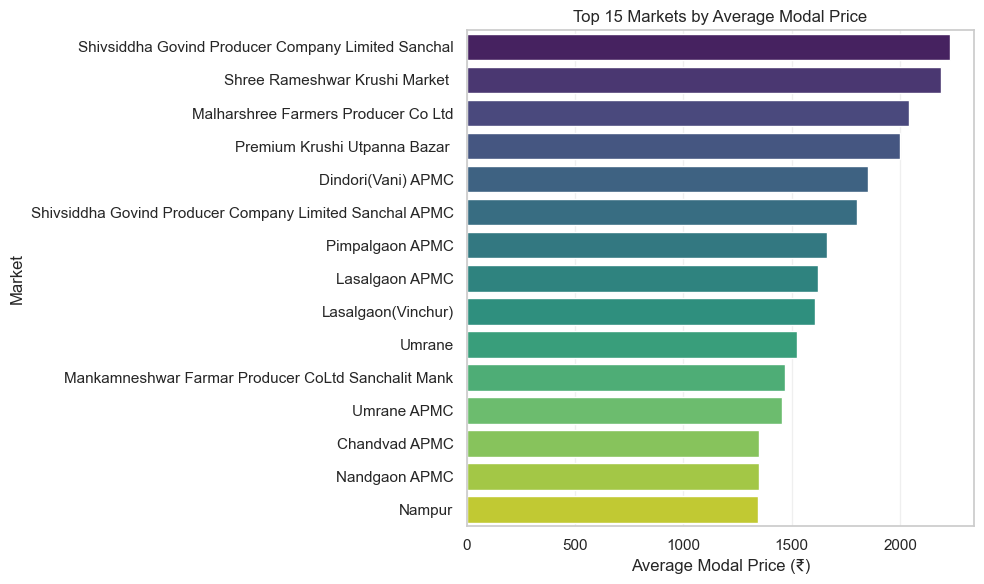

In [57]:
# Top markets by average modal price
top_markets = df_clean.groupby('market')['modal_price'].mean().sort_values(ascending=False).head(15)
sns.barplot(x=top_markets.values, y=top_markets.index, palette='viridis')
plt.title("Top 15 Markets by Average Modal Price")
plt.xlabel("Average Modal Price (₹)")
plt.ylabel("Market")
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

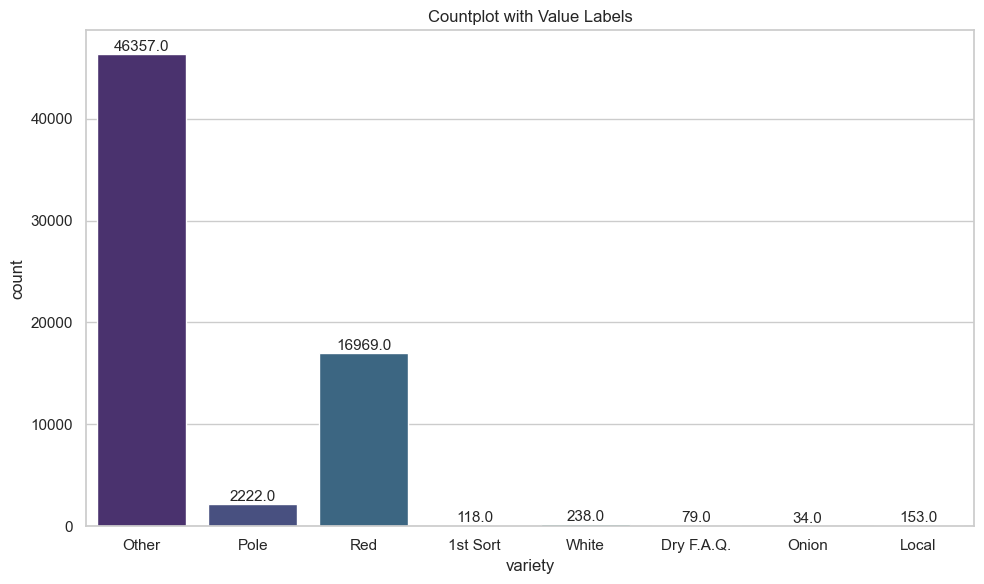

In [58]:
ax = sns.countplot(data=df, x='variety',palette='viridis')
for p in ax.patches:
    height = p.get_height()
    ax.text( p.get_x() + p.get_width() / 2,height,f'{height}',ha='center', va='bottom', fontsize=11)

plt.title("Countplot with Value Labels")
plt.tight_layout()
plt.show()

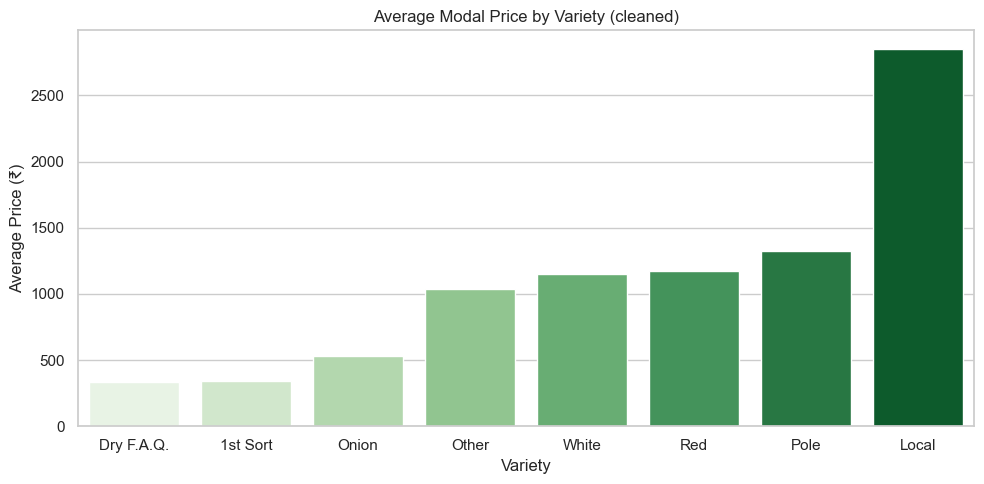

In [59]:
# Average modal price by variety
variety_avg = df_clean.groupby('variety')['modal_price'].mean().sort_values()
plt.figure(figsize=(10,5))
sns.barplot(x=variety_avg.index, y=variety_avg.values, palette='Greens')
plt.title("Average Modal Price by Variety (cleaned)")
plt.xlabel("Variety"); plt.ylabel("Average Price (₹)")
plt.tight_layout()
plt.show()

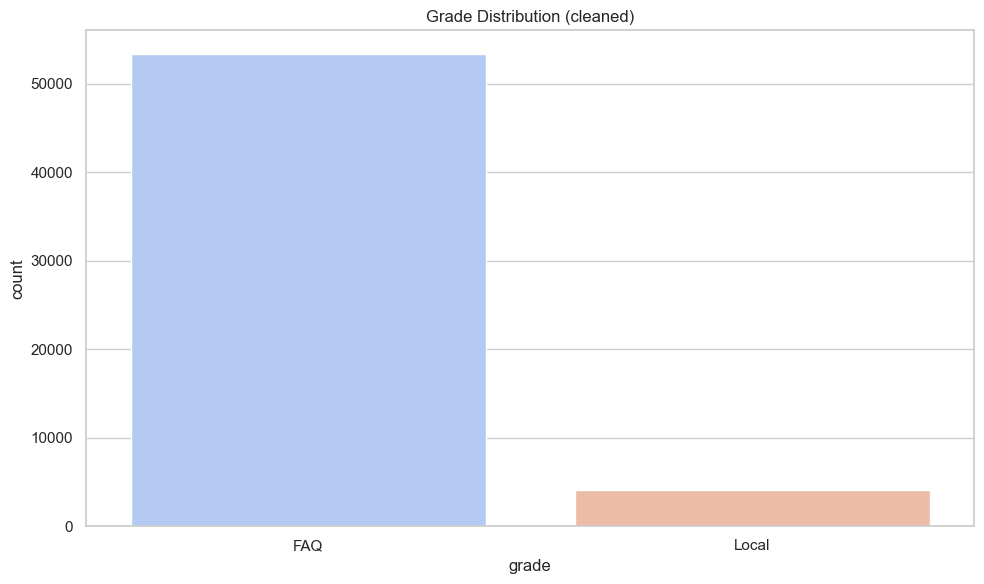

In [60]:
# Grade distribution (cleaned)
sns.countplot(data=df_clean, x='grade', palette='coolwarm')
plt.title("Grade Distribution (cleaned)")
plt.tight_layout()
plt.show()

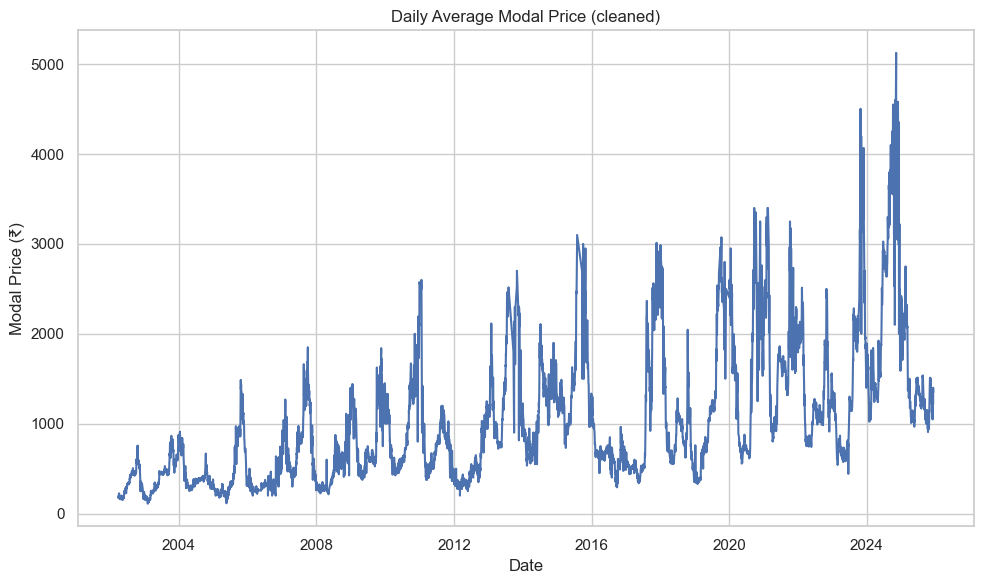

In [61]:
# Daily trend (use aggregated daily mean)
df_daily = df_clean.groupby('arrival_date')['modal_price'].mean().reset_index()
sns.lineplot(data=df_daily, x='arrival_date', y='modal_price')
plt.title("Daily Average Modal Price (cleaned)")
plt.xlabel("Date"); plt.ylabel("Modal Price (₹)")
plt.tight_layout()
plt.show()

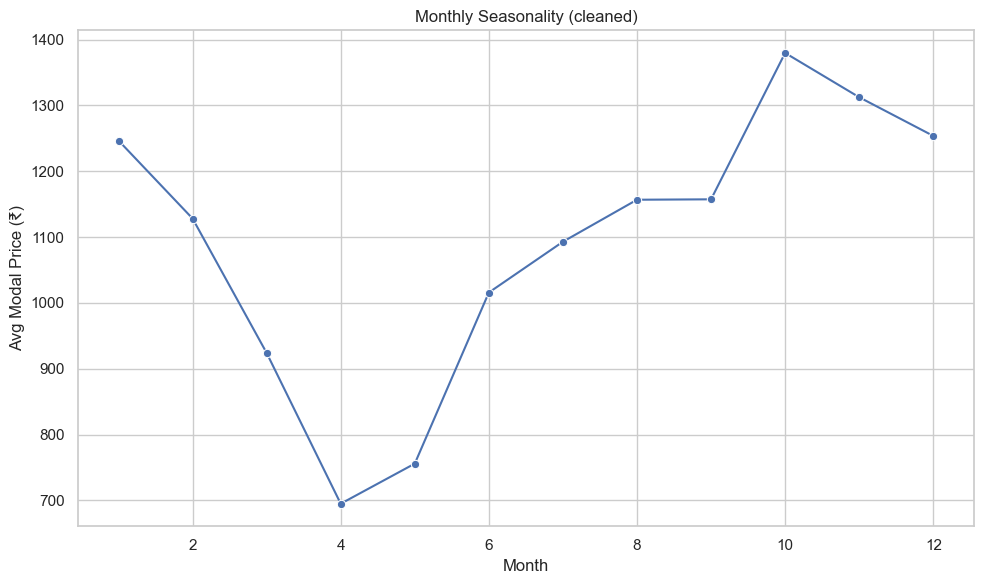

In [62]:
# Monthly seasonality (aggregate across years)
df_monthly = df_clean.groupby('month')['modal_price'].mean().reset_index()
sns.lineplot(data=df_monthly, x='month', y='modal_price', marker='o')
plt.title("Monthly Seasonality (cleaned)")
plt.xlabel("Month"); plt.ylabel("Avg Modal Price (₹)")
plt.tight_layout()
plt.show()

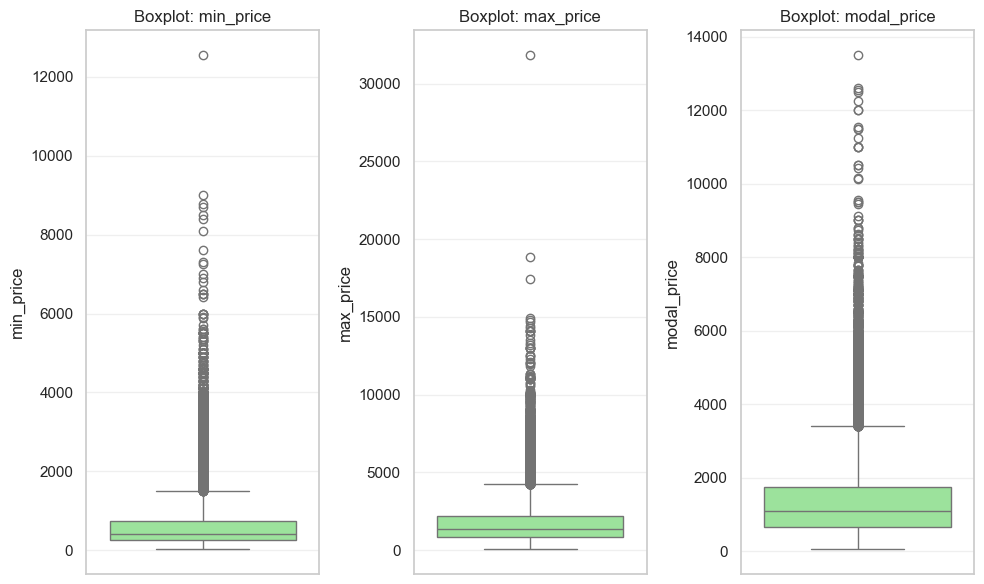

In [63]:
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=df[col], color="lightgreen")
    plt.title(f"Boxplot: {col}", fontsize=12)
    plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


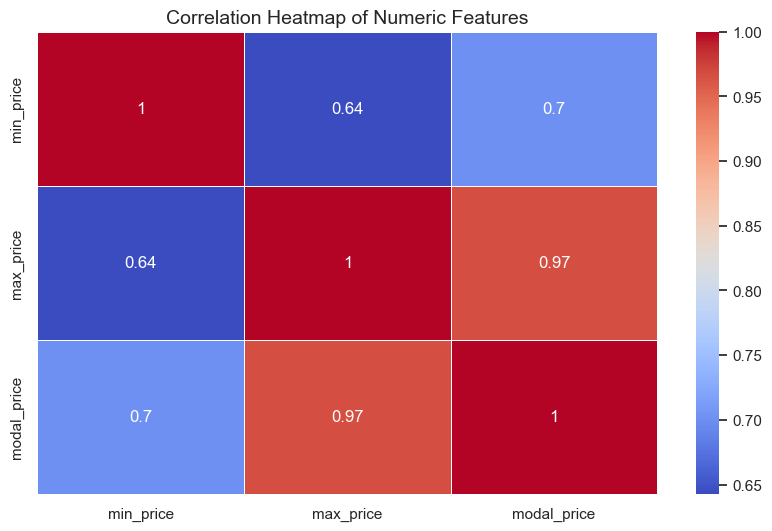

In [64]:
corr = df_clean[['min_price', 'max_price', 'modal_price']].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Features", fontsize=14)
plt.show()

In [65]:
!pip install xgboost

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df_ml = df_clean.copy()

X = df_ml[['market', 'variety', 'grade', 'year', 'month', 'day', 'min_price', 'max_price']]
y = df_ml['modal_price']

cat_cols = ['market', 'variety', 'grade']
num_cols = ['year', 'month', 'day','min_price', 'max_price']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('num', StandardScaler(), num_cols)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train Shape:", X_train.shape)
print("Test Shape:", X_test.shape)

Train Shape: (45979, 8)
Test Shape: (11495, 8)


In [67]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

models = {
    "Linear Regression": LinearRegression(),

    "Decision Tree": DecisionTreeRegressor(max_depth=12, random_state=42),

    "Random Forest": RandomForestRegressor(
        n_estimators=100,
        max_depth=12,
        random_state=42
    ),

    "Gradient Boosting": GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5
    ),

    "XGBoost": XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=7,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="rmse"
    ),

    "KNN Regressor": KNeighborsRegressor(n_neighbors=8)
}

In [22]:
trained_pipes = {}
results = []

for name, model_obj in models.items():

    pipe = Pipeline(steps=[
        ('preprocess', preprocessor),
        ('model', model_obj)
    ])

    pipe.fit(X_train, y_train)
    trained_pipes[name] = pipe
    y_pred = pipe.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results.append([name, mae, rmse, r2])

    print(f"\n{name} Results:")
    print("MAE :", mae)
    print("RMSE:", rmse)
    print("R²  :", r2)


Linear Regression Results:
MAE : 88.72999400360146
RMSE: 132.53299290607896
R²  : 0.9521720278319795

Decision Tree Results:
MAE : 76.54844419914325
RMSE: 120.84675819457219
R²  : 0.9602347272012075

Random Forest Results:
MAE : 68.01414930660027
RMSE: 103.99568217552454
R²  : 0.9705514054228154

Gradient Boosting Results:
MAE : 69.12251052590251
RMSE: 104.87778184658676
R²  : 0.9700497160676052

XGBoost Results:
MAE : 59.472465930515604
RMSE: 91.46049585908379
R²  : 0.9772227619815651

KNN Regressor Results:
MAE : 85.26510852544584
RMSE: 123.23594731565994
R²  : 0.958646833251152


In [25]:
results_df = pd.DataFrame(results, columns=["Model", "MAE", "RMSE", "R² Score"]) 
results_df = results_df.sort_values(by="R² Score", ascending=False) 

print("\nMODEL COMPARISON") 
display(results_df)

best_model_name = results_df.iloc[0]["Model"]
print("Best Model is:", best_model_name)


MODEL COMPARISON


,Model,MAE,RMSE,R² Score
4,XGBoost,59.472466,91.460496,0.977223
2,Random Forest,68.014149,103.995682,0.970551
3,Gradient Boosting,69.122511,104.877782,0.970050
1,Decision Tree,76.548444,120.846758,0.960235
5,KNN Regressor,85.265109,123.235947,0.958647
0,Linear Regression,88.729994,132.532993,0.952172


Best Model is: XGBoost


In [26]:
import joblib

best_pipe = trained_pipes["XGBoost"]

joblib.dump(best_pipe, "onion_price_xgboost.pkl")
print("XGBoost model saved successfully!")

XGBoost model saved successfully!


In [35]:
model = joblib.load("onion_price_xgboost.pkl")
print("Model loaded successfully!")

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\nVerification of Saved Model:")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R² Score (should be ≈ 0.98): {r2:.2f}")

Model loaded successfully!

Verification of Saved Model:
MAE  : 59.47
RMSE : 91.46
R² Score (should be ≈ 0.98): 0.98


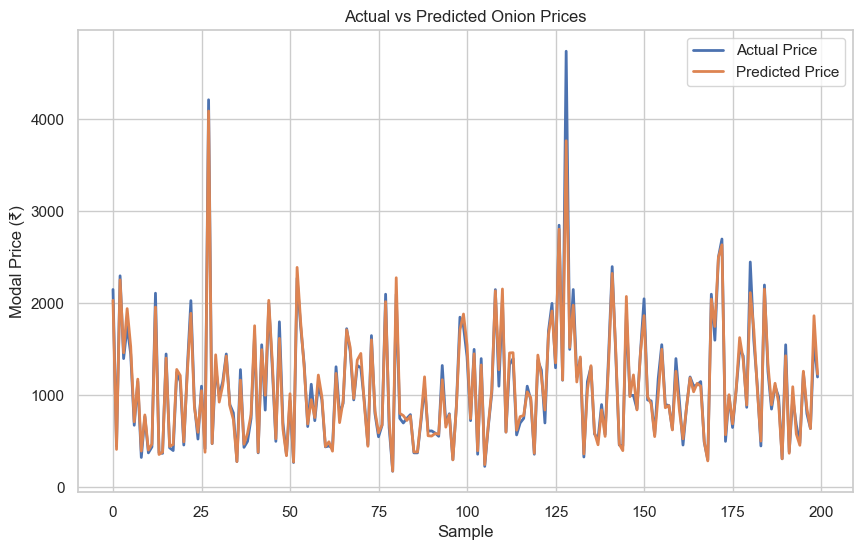

In [36]:
plt.plot(y_test.values[:200], label="Actual Price", linewidth=2)
plt.plot(y_pred[:200], label="Predicted Price", linewidth=2)
plt.title("Actual vs Predicted Onion Prices")
plt.xlabel("Sample")
plt.ylabel("Modal Price (₹)")
plt.legend()
plt.grid(True)
plt.show()


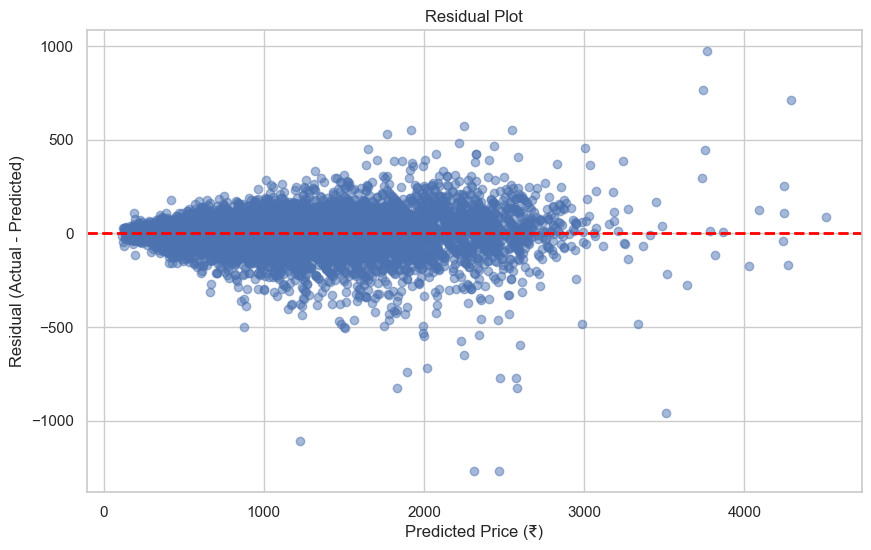

In [38]:
y_pred = best_pipe.predict(X_test)
residuals = y_test - y_pred

plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.title("Residual Plot")
plt.xlabel("Predicted Price (₹)")
plt.ylabel("Residual (Actual - Predicted)")
plt.grid(True)
plt.show()